In [ ]:
import pandas as pd
import os
from google.colab import files
import numpy as np

# Step 1: Upload CSV File
uploaded = files.upload()

# Define the fixed filename and the required columns for the dataset
FIXED_FILENAME = "crime_data.csv"  # Ensure the uploaded file is named this

# Required columns for the dataset
required_columns = [
    'Crime ID', 'Date & Time', 'Latitude', 'Longitude', 'Crime Type', 'Severity',
    'Police Station Jurisdiction', 'Weather', 'Population Density', 'Proximity to Landmark (meters)',
    'Time of Day', 'Day of the Week', 'Holiday/Non-Holiday', 'Recurring Crime Location',
    'Victim Age Group', 'Suspect Age Group', 'Weapon Involved', 'Arrest Made',
    'Criminal Record Found', 'Number of Victims', 'Emergency Response Time (minutes)',
    'Crime Recorded by CCTV', 'Witnesses Present', 'Area Type', 'Economic Status of Area',
    'Traffic Density', 'Nearby Facilities', 'Reporting Time (minutes)'
]

# Step 2: Read the uploaded CSV file
try:
    # Assuming the uploaded file is named 'crime_data.csv'
    crime_data = pd.read_csv(FIXED_FILENAME)

    # Check if the CSV contains the required columns
    if not all(col in crime_data.columns for col in required_columns):
        print("CSV is missing required columns.")
    else:
        print("CSV file successfully loaded.")

        # Step 3: Process and clean the data (apply mappings to categorical columns)
        # Mapping categorical values to numerical values
        mappings = {
            'Crime Type': {'Kidnapping': 1, 'Homicide': 2, 'Robbery': 3, 'Burglary': 4, 'Vandalism': 5},
            'Severity': {'Low': 1, 'Moderate': 2, 'High': 3},
            'Weather': {'Sunny': 1, 'Cloudy': 2, 'Rainy': 3, 'Foggy': 4},
            'Area Type': {'Urban': 1, 'Suburban': 2, 'Rural': 3},
            'Economic Status of Area': {'Low': 1, 'Medium': 2, 'High': 3},
            'Traffic Density': {'Low': 1, 'Medium': 2, 'High': 3}
        }

        crime_prediction_dataset = crime_data[[
            'Crime Type', 'Severity', 'Latitude', 'Longitude', 'Weather',
            'Population Density', 'Area Type', 'Economic Status of Area',
            'Traffic Density'
        ]].copy()

        for column, mapping in mappings.items():
            crime_prediction_dataset[column] = crime_prediction_dataset[column].apply(lambda x: mapping.get(x, 5 if column == 'Crime Type' else 1))

        # Step 4: Display a preview of the transformed data
        data_preview = crime_prediction_dataset.head(10).to_dict(orient='records')
        print("Data Preview:")
        print(data_preview)

        # Step 5: Save the cleaned and processed dataset if needed
        processed_data_path = "crime_prediction_dataset.csv"
        crime_prediction_dataset.to_csv(processed_data_path, index=False)
        print(f"Processed data saved at {processed_data_path}")

        # Optionally, download the processed file
        files.download(processed_data_path)

except Exception as e:
    print(f"An error occurred: {str(e)}")

Saving crime_data.csv to crime_data.csv
CSV file successfully loaded.
Data Preview:
[{'Crime Type': 1, 'Severity': 3, 'Latitude': 22.589935, 'Longitude': 88.411624, 'Weather': 2, 'Population Density': 3359, 'Area Type': 1, 'Economic Status of Area': 1, 'Traffic Density': 1}, {'Crime Type': 2, 'Severity': 3, 'Latitude': 13.129479, 'Longitude': 80.289806, 'Weather': 2, 'Population Density': 1162, 'Area Type': 1, 'Economic Status of Area': 1, 'Traffic Density': 1}, {'Crime Type': 1, 'Severity': 2, 'Latitude': 13.127055, 'Longitude': 80.294069, 'Weather': 4, 'Population Density': 9231, 'Area Type': 3, 'Economic Status of Area': 2, 'Traffic Density': 2}, {'Crime Type': 3, 'Severity': 1, 'Latitude': 13.004048, 'Longitude': 77.637241, 'Weather': 3, 'Population Density': 5057, 'Area Type': 3, 'Economic Status of Area': 2, 'Traffic Density': 2}, {'Crime Type': 4, 'Severity': 1, 'Latitude': 13.013586, 'Longitude': 77.544763, 'Weather': 4, 'Population Density': 4621, 'Area Type': 2, 'Economic Sta

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hotspot map saved at: hotspot_map.png
Hotspots detected: [{'cluster_id': 0, 'latitude': 26.851622, 'longitude': 80.941163, 'density': 57}, {'cluster_id': 1, 'latitude': 13.008644, 'longitude': 77.643184, 'density': 148}, {'cluster_id': 2, 'latitude': 19.122997, 'longitude': 72.882328, 'density': 157}, {'cluster_id': 3, 'latitude': 26.958515, 'longitude': 75.832428, 'density': 86}, {'cluster_id': 4, 'latitude': 22.570203, 'longitude': 88.37259, 'density': 52}]


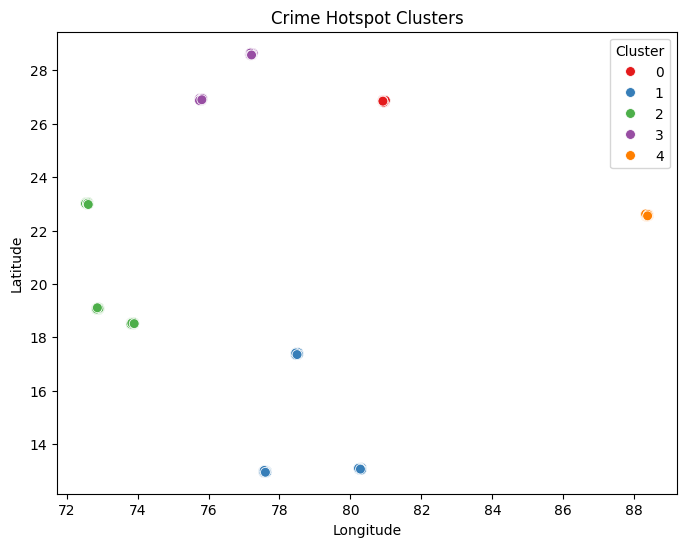

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans


def detect_hotspots(csv_path):
    # Check if file exists
    if not os.path.exists(csv_path):
        return {"error": "CSV file not found."}

    try:
        crime_data = pd.read_csv(csv_path)
    except Exception as e:
        return {"error": f"Error loading CSV: {str(e)}"}

    # Ensure required columns exist
    required_columns = {"Latitude", "Longitude"}
    if not required_columns.issubset(crime_data.columns):
        return {"error": "Invalid CSV format"}

    # Remove invalid lat/lon values (out of range)
    crime_data = crime_data[(crime_data["Latitude"].between(-90, 90)) & (crime_data["Longitude"].between(-180, 180))]

    # Extract relevant data
    locations = crime_data[['Latitude', 'Longitude']].dropna().copy()

    if locations.shape[0] < 5:
        return {"error": "Not enough data for clustering."}

    # Apply K-Means Clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    locations['Cluster'] = kmeans.fit_predict(locations)

    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Find nearest actual data points to each cluster center
    def find_nearest_location(center, locations_df):
        return locations_df.iloc[np.argmin(locations_df.apply(lambda row: euclidean(center, [row['Latitude'], row['Longitude']]), axis=1))]

    hotspots = []
    for i, center in enumerate(cluster_centers):
        nearest_point = find_nearest_location(center, locations)
        hotspots.append({
            "cluster_id": i,
            "latitude": round(nearest_point["Latitude"], 6),
            "longitude": round(nearest_point["Longitude"], 6),
            "density": locations[locations["Cluster"] == i].shape[0]
        })

    # Generate a heatmap visualization
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=locations["Longitude"], y=locations["Latitude"], hue=locations["Cluster"], palette="Set1", s=50)
    plt.title("Crime Hotspot Clusters")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title="Cluster")

    # Save the generated map
    hotspot_map_path = "hotspot_map.png"
    plt.savefig(hotspot_map_path, format="png", bbox_inches="tight")
    plt.close()

    return {"hotspot_map": hotspot_map_path, "hotspots": hotspots}

# Path to the uploaded file
FIXED_FILENAME="crime_data.csv"
# Detect hotspots and generate the map
result = detect_hotspots(FIXED_FILENAME)

# Display result
if "error" in result:
    print(result["error"])
else:
    print(f"Hotspot map saved at: {result['hotspot_map']}")
    print("Hotspots detected:", result["hotspots"])
    # Display the map in Colab
    from IPython.display import Image
    display(Image(result["hotspot_map"]))

Hotspot map saved at: hotspot_map_with_density.png
Hotspots detected: [{'cluster_id': 0, 'latitude': 26.851622, 'longitude': 80.941163, 'density': 57}, {'cluster_id': 1, 'latitude': 13.008644, 'longitude': 77.643184, 'density': 148}, {'cluster_id': 2, 'latitude': 19.122997, 'longitude': 72.882328, 'density': 157}, {'cluster_id': 3, 'latitude': 26.958515, 'longitude': 75.832428, 'density': 86}, {'cluster_id': 4, 'latitude': 22.570203, 'longitude': 88.37259, 'density': 52}]


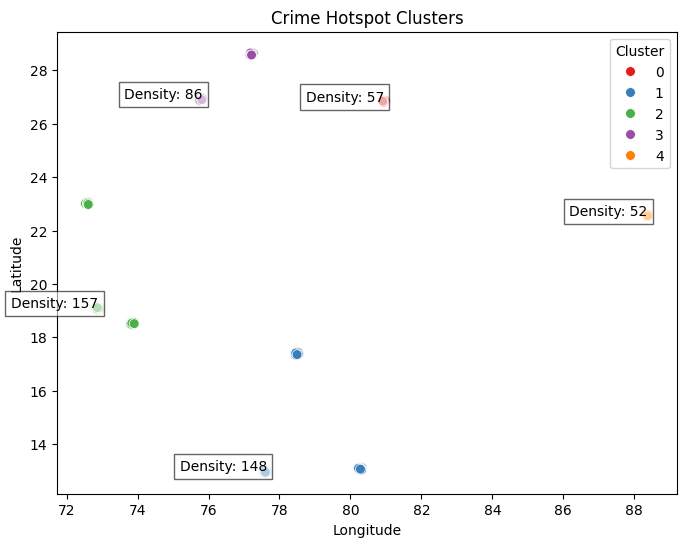

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans

def detect_hotspots(csv_path):
    # Check if file exists
    if not os.path.exists(csv_path):
        return {"error": "CSV file not found."}

    try:
        crime_data = pd.read_csv(csv_path)
    except Exception as e:
        return {"error": f"Error loading CSV: {str(e)}"}

    # Ensure required columns exist
    required_columns = {"Latitude", "Longitude"}
    if not required_columns.issubset(crime_data.columns):
        return {"error": "Invalid CSV format"}

    # Remove invalid lat/lon values (out of range)
    crime_data = crime_data[(crime_data["Latitude"].between(-90, 90)) & (crime_data["Longitude"].between(-180, 180))]

    # Extract relevant data
    locations = crime_data[['Latitude', 'Longitude']].dropna().copy()

    if locations.shape[0] < 5:
        return {"error": "Not enough data for clustering."}

    # Apply K-Means Clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    locations['Cluster'] = kmeans.fit_predict(locations)

    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Find nearest actual data points to each cluster center
    def find_nearest_location(center, locations_df):
        return locations_df.iloc[np.argmin(locations_df.apply(lambda row: euclidean(center, [row['Latitude'], row['Longitude']]), axis=1))]

    hotspots = []
    for i, center in enumerate(cluster_centers):
        nearest_point = find_nearest_location(center, locations)
        hotspots.append({
            "cluster_id": i,
            "latitude": round(nearest_point["Latitude"], 6),
            "longitude": round(nearest_point["Longitude"], 6),
            "density": locations[locations["Cluster"] == i].shape[0]  # Density = number of points in cluster
        })

    # Generate a scatter plot with density annotations
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(x=locations["Longitude"], y=locations["Latitude"], hue=locations["Cluster"], palette="Set1", s=50)
    plt.title("Crime Hotspot Clusters")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title="Cluster")

    # Annotate each cluster with its density value
    for hotspot in hotspots:
        plt.text(hotspot["longitude"], hotspot["latitude"], f'Density: {hotspot["density"]}',
                 fontsize=10, color='black', ha='right', bbox=dict(facecolor='white', alpha=0.6))

    # Save the updated map
    hotspot_map_path = "hotspot_map_with_density.png"
    plt.savefig(hotspot_map_path, format="png", bbox_inches="tight")
    plt.close()

    return {"hotspot_map": hotspot_map_path, "hotspots": hotspots}

# Path to the uploaded file
FIXED_FILENAME = "crime_data.csv"

# Detect hotspots and generate the map
result = detect_hotspots(FIXED_FILENAME)

# Display result
if "error" in result:
    print(result["error"])
else:
    print(f"Hotspot map saved at: {result['hotspot_map']}")
    print("Hotspots detected:", result["hotspots"])

    # Display the map (for Jupyter Notebook or Google Colab)
    from IPython.display import Image
    display(Image(result["hotspot_map"]))


In [ ]:
import pandas as pd
import os
from google.colab import files
import numpy as np

# Step 1: Upload CSV File
uploaded = files.upload()

# Define the fixed filename and the required columns for the dataset
FIXED_FILENAME = "crime_data.csv"  # Ensure the uploaded file is named this

# Required columns for the dataset
required_columns = [
    'Crime ID', 'Date & Time', 'Latitude', 'Longitude', 'Crime Type', 'Severity',
    'Police Station Jurisdiction', 'Weather', 'Population Density', 'Proximity to Landmark (meters)',
    'Time of Day', 'Day of the Week', 'Holiday/Non-Holiday', 'Recurring Crime Location',
    'Victim Age Group', 'Suspect Age Group', 'Weapon Involved', 'Arrest Made',
    'Criminal Record Found', 'Number of Victims', 'Emergency Response Time (minutes)',
    'Crime Recorded by CCTV', 'Witnesses Present', 'Area Type', 'Economic Status of Area',
    'Traffic Density', 'Nearby Facilities', 'Reporting Time (minutes)'
]

# Step 2: Read the uploaded CSV file
try:
    # Assuming the uploaded file is named 'crime_data.csv'
    crime_data = pd.read_csv(FIXED_FILENAME)

    # Check if the CSV contains the required columns
    if not all(col in crime_data.columns for col in required_columns):
        print("CSV is missing required columns.")
    else:
        print("CSV file successfully loaded.")

        # Step 3: Process and clean the data (apply mappings to categorical columns)
        # Mapping categorical values to numerical values
        mappings = {
            'Crime Type': {1: 'Kidnapping', 2: 'Robbery', 3: 'Burglary', 4: 'Assault', 5: 'Theft', 6: 'Other'},
    'Severity': {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Moderate'},
    'Weather': {0: 'Cloudy', 1: 'Foggy', 2: 'Rainy', 3: 'Sunny'},
    'Area Type': {0: 'Urban', 1: 'Rural', 2: 'Suburban'},
    'Economic Status of Area': {0: 'Low', 1: 'Medium', 2: 'High'},
    'Traffic Density': {0: 'Low', 1: 'Medium', 2: 'High'}
        }

        crime_prediction_dataset = crime_data[[
            'Crime Type', 'Severity', 'Latitude', 'Longitude', 'Weather',
            'Population Density', 'Area Type', 'Economic Status of Area',
            'Traffic Density'
        ]].copy()

        for column, mapping in mappings.items():
            crime_prediction_dataset[column] = crime_prediction_dataset[column].apply(lambda x: mapping.get(x, 5 if column == 'Crime Type' else 1))

        # Step 4: Display a preview of the transformed data
        data_preview = crime_prediction_dataset.head(10).to_dict(orient='records')
        print("Data Preview:")
        print(data_preview)

        # Step 5: Save the cleaned and processed dataset if needed
        processed_data_path = "crime_prediction_dataset.csv"
        crime_prediction_dataset.to_csv(processed_data_path, index=False)
        print(f"Processed data saved at {processed_data_path}")

        # Optionally, download the processed file
        files.download(processed_data_path)

except Exception as e:
    print(f"An error occurred: {str(e)}")


Saving crime_data.csv to crime_data (1).csv
CSV file successfully loaded.
Data Preview:
[{'Crime Type': 5, 'Severity': 1, 'Latitude': 22.589935, 'Longitude': 88.411624, 'Weather': 1, 'Population Density': 3359, 'Area Type': 1, 'Economic Status of Area': 1, 'Traffic Density': 1}, {'Crime Type': 5, 'Severity': 1, 'Latitude': 13.129479, 'Longitude': 80.289806, 'Weather': 1, 'Population Density': 1162, 'Area Type': 1, 'Economic Status of Area': 1, 'Traffic Density': 1}, {'Crime Type': 5, 'Severity': 1, 'Latitude': 13.127055, 'Longitude': 80.294069, 'Weather': 1, 'Population Density': 9231, 'Area Type': 1, 'Economic Status of Area': 1, 'Traffic Density': 1}, {'Crime Type': 5, 'Severity': 1, 'Latitude': 13.004048, 'Longitude': 77.637241, 'Weather': 1, 'Population Density': 5057, 'Area Type': 1, 'Economic Status of Area': 1, 'Traffic Density': 1}, {'Crime Type': 5, 'Severity': 1, 'Latitude': 13.013586, 'Longitude': 77.544763, 'Weather': 1, 'Population Density': 4621, 'Area Type': 1, 'Economic

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def train_model_crime(request):
    if 'aname' not in request.session:
        return redirect('user_login')

    csv_path = os.path.join(settings.MEDIA_ROOT, FIXED_FILENAME)

    if not os.path.exists(csv_path):
        messages.error(request, "No dataset file exists.")
        return render(request, 'User/success_train_msg.html')

    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        messages.error(request, f"Error reading file: {str(e)}")
        return render(request, 'User/success_train_msg.html')

    required_columns = ["Date & Time", "Cluster", "Weather", "Population Density", "Time of Day",
                        "Day of the Week", "Holiday/Non-Holiday", "Economic Status of Area"]

    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        messages.error(request, f"Missing required columns: {', '.join(missing_cols)}")
        return render(request, 'Master/success_train_msg.html')

    # Convert Date & Time to separate features
    df["Date & Time"] = pd.to_datetime(df["Date & Time"], errors='coerce')
    df["Year"] = df["Date & Time"].dt.year
    df["Month"] = df["Date & Time"].dt.month
    df["Day"] = df["Date & Time"].dt.day
    df["Hour"] = df["Date & Time"].dt.hour
    df["Minute"] = df["Date & Time"].dt.minute
    df["Weekday"] = df["Date & Time"].dt.weekday
    df.drop(columns=["Date & Time"], inplace=True)

    # Convert categorical features to numeric using one-hot encoding
    categorical_columns = ["Weather", "Time of Day", "Day of the Week", "Holiday/Non-Holiday", "Economic Status of Area"]
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    # Ensure numeric data only
    df = df.select_dtypes(include=['number'])

    if "Cluster" not in df.columns:
        messages.error(request, "No numeric columns left for training.")
        return render(request, 'Master/success_train_msg.html')

    X = df.drop(columns=["Cluster"])
    y = df["Cluster"]

    X.fillna(X.median(numeric_only=True), inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    try:
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Generate classification report
        class_report = classification_report(y_test, y_pred, output_dict=True)

    except Exception as e:
        messages.error(request, f"Error training model: {str(e)}")
        return render(request, 'Master/success_train_msg.html')

    # Save model
    model_dir = os.path.join(settings.MEDIA_ROOT, "Detection")
    os.makedirs(model_dir, exist_ok=True)
    joblib.dump(model, os.path.join(model_dir, "crime_hotspot_model.pkl"))
    for label, metrics in class_report.items():
        if isinstance(metrics, dict):
            metrics['f1_score'] = metrics.pop('f1-score', None)  # Avoid KeyError
    context = {
        "accuracy": accuracy,
        "classification_report": class_report
    }

In [ ]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from google.colab import files

# Step 2: Upload dataset manually or load from Google Drive
  # Mount Google Drive (if dataset is in Drive)

# Provide the correct path of your dataset
dataset_path = "crime_prediction_dataset.csv"  # Change this path
data = pd.read_csv(dataset_path)

# Step 3: Prepare features and target
X = data.drop(columns=['Crime Type'])  # Assuming 'Crime Type' is the target variable
y = data['Crime Type']

# Step 4: Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 5: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 7: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Print Accuracy
# print("Accuracy:", accuracy * 100)

# # Display Classification Report
# print("Classification Report:\n", classification_report(y_test, y_pred))

# # Display Confusion Matrix
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# print("Accuracy:", accuracy * 100)

# Step 8: Save model and scaler
joblib.dump(model, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Step 9: Download the trained model and scaler
files.download('rf_model.pkl')
files.download('scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
import pandas as pd
import numpy as np

# Load the trained model and scaler
model_path = 'rf_model.pkl'  # Change this if needed
scaler_path = 'scaler.pkl'    # Change this if needed

model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

# Define feature names (same as used during training)
feature_names = [
    'Severity', 'Latitude', 'Longitude', 'Weather',
    'Population Density', 'Area Type', 'Economic Status of Area', 'Traffic Density'
]

# Direct Input Values
severity = 8# Moderate
latitude = 17.0522  # Example (Los Angeles)
longitude = -87.2437
weather = 3  # Cloudy
population_density = 3500  # High density
area_type = 2 # Urban
economic_status = 3  # Medium
traffic_density = 0  # High




# Prepare input data
input_data = pd.DataFrame([{
    'Severity': severity,
    'Latitude': latitude,
    'Longitude': longitude,
    'Weather': weather,
    'Population Density': population_density,
    'Area Type': area_type,
    'Economic Status of Area': economic_status,
    'Traffic Density': traffic_density
}])

# Ensure expected columns exist
for col in feature_names:
    if col not in input_data.columns:
        input_data[col] = 0  # Default missing columns to 0

# Reorder columns to match training data
input_data = input_data[feature_names]

# Scale numerical features
input_data_scaled = scaler.transform(input_data)

# Make prediction
prediction = model.predict(input_data_scaled)
predicted_crime_type = prediction[0]

# Define category mappings

mappings = {
   'Crime Type': {1: 'Kidnapping', 2: 'Homicide', 3: 'Robbery', 4: 'Burglary', 5: 'Vandalism', 6: 'Assault',7:'Other'},
    'Severity': {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Moderate'},
    'Weather': {0: 'Cloudy', 1: 'Foggy', 2: 'Rainy', 3: 'Sunny'},
    'Area Type': {0: 'Urban', 1: 'Rural', 2: 'Suburban'},
    'Economic Status of Area': {0: 'Low', 1: 'Medium', 2: 'High'},
    'Traffic Density': {0: 'Low', 1: 'Medium', 2: 'High'}
}

# Convert prediction to human-readable format
crime_type_label = mappings['Crime Type'].get(predicted_crime_type, 'Unknown')

# Output Results
print(f"🔹 **Predicted Crime Type:** {crime_type_label}")



🔹 **Predicted Crime Type:** Burglary


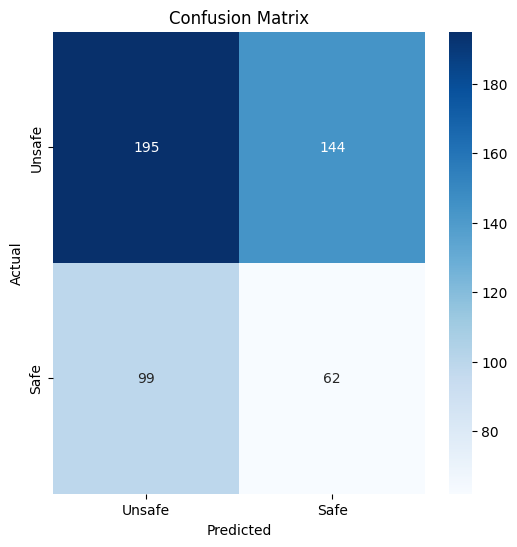

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the dataset
file_path = "/content/crime_data.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Define actual labels based on 'Severity'
df["Actual"] = df["Severity"].apply(lambda x: "Unsafe" if x in ["High", "Moderate"] else "Safe")

# Define predicted labels based on 'Cluster' (adjusting threshold if necessary)
df["Predicted"] = df["Cluster"].apply(lambda x: "Unsafe" if x > 1 else "Safe")

# Compute the confusion matrix
cm = confusion_matrix(df["Actual"], df["Predicted"], labels=["Unsafe", "Safe"])

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Unsafe", "Safe"], yticklabels=["Unsafe", "Safe"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



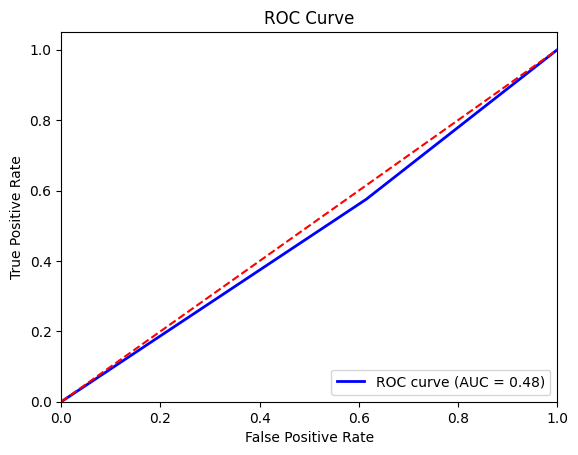

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Given confusion matrix values
TP = 195  # True Positives
FN = 144  # False Negatives
FP = 99   # False Positives
TN = 62   # True Negatives

# Actual labels (1 for Unsafe, 0 for Safe)
y_actual = np.array([1] * (TP + FN) + [0] * (FP + TN))

# Predicted probabilities (simulating based on confusion matrix)
y_scores = np.array([1] * TP + [0] * FN + [1] * FP + [0] * TN)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_actual, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


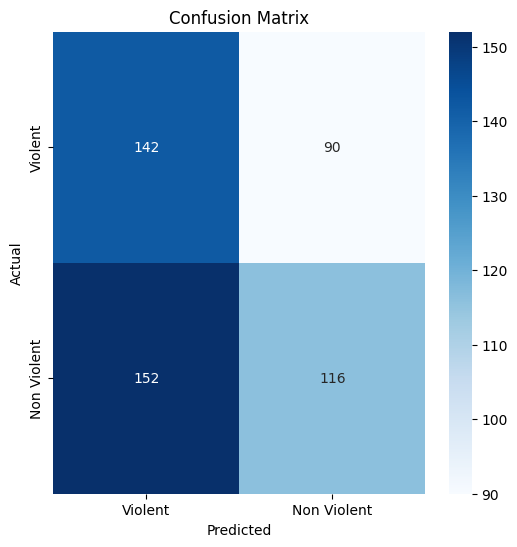

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the dataset
file_path = "/content/crime_data.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Define actual labels based on 'Crime Type'
df["Actual"] = df["Crime Type"].apply(lambda x: "Violent" if x in ["Kidnapping", "Homicide","Assault"] else "Non Violent")

# Define predicted labels based on 'Cluster' (adjusting threshold if necessary)
df["Predicted"] = df["Cluster"].apply(lambda x: "Violent" if x > 1 else "Non Violent")

# Compute the confusion matrix
cm = confusion_matrix(df["Actual"], df["Predicted"], labels=["Violent", "Non Violent"])

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Violent", "Non Violent"], yticklabels=["Violent", "Non Violent"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pandas as pd

# Load the dataset
file_path = "/content/crime_data.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Display unique crime types
crime_types = df["Crime Type"].unique()
print(crime_types)


['Kidnapping' 'Homicide' 'Robbery' 'Burglary' 'Vandalism' 'Assault']


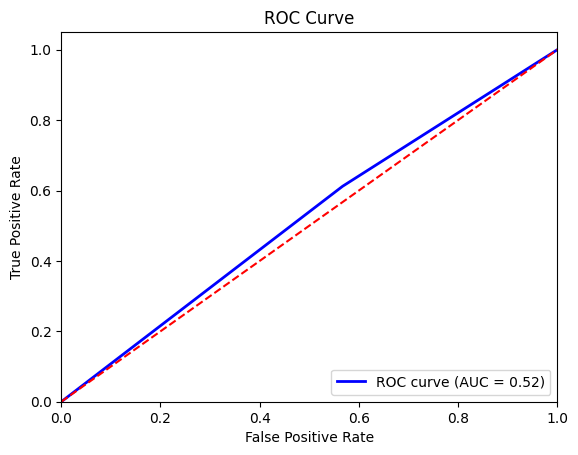

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Given confusion matrix values
TP = 142  # True Positives
FN = 90  # False Negatives
FP = 152   # False Positives
TN = 116   # True Negatives

# Actual labels (1 for Unsafe, 0 for Safe)
y_actual = np.array([1] * (TP + FN) + [0] * (FP + TN))

# Predicted probabilities (simulating based on confusion matrix)
y_scores = np.array([1] * TP + [0] * FN + [1] * FP + [0] * TN)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_actual, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import pandas as pd
import os
from google.colab import files
import numpy as np

# Step 1: Upload CSV File
uploaded = files.upload()

# Define the fixed filename and the required columns for the dataset
FIXED_FILENAME = "crime_data.csv"  # Ensure the uploaded file is named this

# Required columns for the dataset
required_columns = [
    'Crime ID', 'Date & Time', 'Latitude', 'Longitude', 'Crime Type', 'Severity',
    'Police Station Jurisdiction', 'Weather', 'Population Density', 'Proximity to Landmark (meters)',
    'Time of Day', 'Day of the Week', 'Holiday/Non-Holiday', 'Recurring Crime Location',
    'Victim Age Group', 'Suspect Age Group', 'Weapon Involved', 'Arrest Made',
    'Criminal Record Found', 'Number of Victims', 'Emergency Response Time (minutes)',
    'Crime Recorded by CCTV', 'Witnesses Present', 'Area Type', 'Economic Status of Area',
    'Traffic Density', 'Nearby Facilities', 'Reporting Time (minutes)'
]

# Step 2: Read the uploaded CSV file
try:
    # Assuming the uploaded file is named 'crime_data.csv'
    crime_data = pd.read_csv(FIXED_FILENAME)

    # Check if the CSV contains the required columns
    if not all(col in crime_data.columns for col in required_columns):
        print("CSV is missing required columns.")
    else:
        print("CSV file successfully loaded.")

        # Step 3: Process and clean the data (apply mappings to categorical columns)
        # Mapping categorical values to numerical values
        mappings = {
           'Crime Type': {
        'Kidnapping': 1,
        'Homicide': 2,
        'Robbery': 3,
        'Burglary': 4,
        'Vandalism': 5,
        'Assault': 6,
        'Other': 7  # Optionally, you can add a default category if any other type is present
    },
    'Severity': {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Moderate'},
    'Weather': {0: 'Cloudy', 1: 'Foggy', 2: 'Rainy', 3: 'Sunny'},
    'Area Type': {0: 'Urban', 1: 'Rural', 2: 'Suburban'},
    'Economic Status of Area': {0: 'Low', 1: 'Medium', 2: 'High'},
    'Traffic Density': {0: 'Low', 1: 'Medium', 2: 'High'}
        }

        crime_prediction_dataset = crime_data[[
            'Crime Type', 'Severity', 'Latitude', 'Longitude', 'Weather',
            'Population Density', 'Area Type', 'Economic Status of Area',
            'Traffic Density'
        ]].copy()

        for column, mapping in mappings.items():
            crime_prediction_dataset[column] = crime_prediction_dataset[column].apply(lambda x: mapping.get(x, 5 if column == 'Crime Type' else 1))

        # Step 4: Display a preview of the transformed data
        data_preview = crime_prediction_dataset.head(10).to_dict(orient='records')
        print("Data Preview:")
        print(data_preview)

        # Step 5: Save the cleaned and processed dataset if needed
        processed_data_path = "crime_prediction_dataset.csv"
        crime_prediction_dataset.to_csv(processed_data_path, index=False)
        print(f"Processed data saved at {processed_data_path}")

        # Optionally, download the processed file
        files.download(processed_data_path)

except Exception as e:
    print(f"An error occurred: {str(e)}")


Saving crime_data.csv to crime_data (2).csv
CSV file successfully loaded.
Data Preview:
[{'Crime Type': 1, 'Severity': 1, 'Latitude': 22.589935, 'Longitude': 88.411624, 'Weather': 1, 'Population Density': 3359, 'Area Type': 1, 'Economic Status of Area': 1, 'Traffic Density': 1}, {'Crime Type': 2, 'Severity': 1, 'Latitude': 13.129479, 'Longitude': 80.289806, 'Weather': 1, 'Population Density': 1162, 'Area Type': 1, 'Economic Status of Area': 1, 'Traffic Density': 1}, {'Crime Type': 1, 'Severity': 1, 'Latitude': 13.127055, 'Longitude': 80.294069, 'Weather': 1, 'Population Density': 9231, 'Area Type': 1, 'Economic Status of Area': 1, 'Traffic Density': 1}, {'Crime Type': 3, 'Severity': 1, 'Latitude': 13.004048, 'Longitude': 77.637241, 'Weather': 1, 'Population Density': 5057, 'Area Type': 1, 'Economic Status of Area': 1, 'Traffic Density': 1}, {'Crime Type': 4, 'Severity': 1, 'Latitude': 13.013586, 'Longitude': 77.544763, 'Weather': 1, 'Population Density': 4621, 'Area Type': 1, 'Economic

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

def train_and_predict_model(request):
    try:
        # Load dataset
        data = pd.read_csv('media/Detection/crime_prediction_dataset.csv')

        # Separate features and target
        X = data.drop(columns=['Crime Type'])
        y = data['Crime Type']

        # Identify categorical and numerical columns
        categorical_cols = ['Weather', 'Area Type', 'Economic Status of Area']
        numerical_cols = ['Latitude', 'Longitude', 'Severity']

        # One-hot encode categorical features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ]
        )

        X = preprocessor.fit_transform(X)

        # Feature Selection
        selector = SelectKBest(f_classif, k=10)
        X = selector.fit_transform(X, y)

        # Handle class imbalance using SMOTE
        smote = SMOTE(random_state=42)
        X, y = smote.fit_resample(X, y)

        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train Random Forest model
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)

        # Save model
        joblib.dump(model, 'media/Detection/rf_model.pkl')
        joblib.dump(preprocessor, 'media/Detection/preprocessor.pkl')

        # **🔹 Save Confusion Matrix Image**
        cm_img_path = "media/Detection/confusion_matrix.png"
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
        plt.savefig(cm_img_path)
        plt.close()

        # **🔹 Save ROC Curve Image**
        roc_img_path = "media/Detection/roc_curve.png"
        y_test_bin = label_binarize(y_test, classes=list(set(y_test)))
        n_classes = y_test_bin.shape[1]

        plt.figure(figsize=(6, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred == i)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.savefig(roc_img_path)
        plt.close()

        # Process classification report
        class_report_data = [
            {
                "Class": label,
                "Precision": round(metrics["precision"], 2),
                "Recall": round(metrics["recall"], 2),
                "F1_score": round(metrics["f1-score"], 2),
                "Support": int(metrics["support"])
            }
            for label, metrics in class_report.items() if isinstance(metrics, dict)
        ]

        # Return results
        return render(request, 'Master/model_prediction.html', {
            "accuracy": round(accuracy * 100, 2),
            "classification_report": class_report_data,
            "confusion_matrix_img": "confusion_matrix.png",
            "roc_curve_img": "roc_curve.png"
        })

    except Exception as e:
        return JsonResponse({"error": str(e)})


In [ ]:
import joblib
import pandas as pd
import numpy as np

# Load the trained model and scaler
model_path = 'rf_model.pkl'  # Change this if needed
scaler_path = 'scaler.pkl'    # Change this if needed

model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

# Define feature names (same as used during training)
feature_names = [
    'Severity', 'Latitude', 'Longitude', 'Weather',
    'Population Density', 'Area Type', 'Economic Status of Area', 'Traffic Density'
]

# Direct Input Values
severity = 2  # Moderate
latitude = 34.0522  # Example (Los Angeles)
longitude = -118.2437
weather = 0  # Cloudy
population_density = 5000  # High density
area_type = 0  # Urban
economic_status = 1  # Medium
traffic_density = 2  # High




# Prepare input data
input_data = pd.DataFrame([{
    'Severity': severity,
    'Latitude': latitude,
    'Longitude': longitude,
    'Weather': weather,
    'Population Density': population_density,
    'Area Type': area_type,
    'Economic Status of Area': economic_status,
    'Traffic Density': traffic_density
}])

# Ensure expected columns exist
for col in feature_names:
    if col not in input_data.columns:
        input_data[col] = 0  # Default missing columns to 0

# Reorder columns to match training data
input_data = input_data[feature_names]

# Scale numerical features
input_data_scaled = scaler.transform(input_data)

# Make prediction
prediction = model.predict(input_data_scaled)
predicted_crime_type = prediction[0]

# Define category mappings

mappings = {
   'Crime Type': {1: 'Kidnapping', 2: 'Homicide', 3: 'Robbery', 4: 'Burglary', 5: 'Vandalism', 6: 'Assault',7:'Other'},
    'Severity': {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Moderate'},
    'Weather': {0: 'Cloudy', 1: 'Foggy', 2: 'Rainy', 3: 'Sunny'},
    'Area Type': {0: 'Urban', 1: 'Rural', 2: 'Suburban'},
    'Economic Status of Area': {0: 'Low', 1: 'Medium', 2: 'High'},
    'Traffic Density': {0: 'Low', 1: 'Medium', 2: 'High'}
}

# Convert prediction to human-readable format
crime_type_label = mappings['Crime Type'].get(predicted_crime_type, 'Unknown')

# Output Results
print(f"🔹 **Predicted Crime Type:** {crime_type_label}")


🔹 **Predicted Crime Type:** Kidnapping


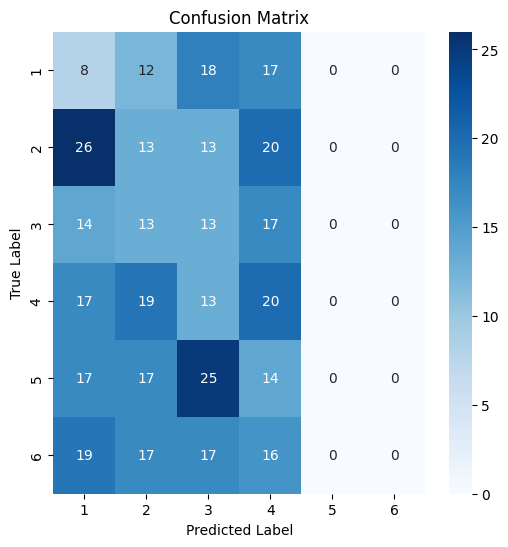

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the dataset
file_path = "/content/crime_data.csv"
df = pd.read_csv(file_path)

# Extract true labels (actual crime types) and predicted labels (clusters)
true_labels = df["Crime Type"].astype('category').cat.codes + 1  # Convert categories to numeric labels
predicted_labels = df["Cluster"]

# Compute the confusion matrix
labels = sorted(true_labels.unique())  # Get unique labels
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()